### Evaluating Large Language Models using LLM-as-a-Judge

Evaluating large language models (LLM) is challenging due to their broad capabilities and the inadequacy of existing benchmarks in measuring human preferences. To address this, strong LLMs are used as judges to evaluate these models on more open-ended questions. The agreement between LLM judges and human preferences has been verified by introducing two benchmarks: Multi Turn (MT)-bench, a multi-turn question set, and Chatbot Arena, a crowdsourced battle platform. The results reveal that strong LLM judges can match both controlled and crowdsourced human preferences well, achieving over 80% agreement, the same level of agreement between humans. This makes LLM-as-a-judge a scalable and explainable way to approximate human preferences, which are otherwise very expensive to obtain.

In [1]:
# Import necessary libraries
import requests
import json

# Download MT-Bench questions
url = "https://raw.githubusercontent.com/lm-sys/FastChat/main/fastchat/llm_judge/data/mt_bench/question.jsonl"
response = requests.get(url)
lines = response.text.split("\n") 

# Iterate through lines and append them to questions array as json
questions = []
for line in lines:
  if line:
    questions.append(json.loads(line))

In [2]:
questions

[{'question_id': 81,
  'category': 'writing',
  'turns': ['Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.',
   'Rewrite your previous response. Start every sentence with the letter A.']},
 {'question_id': 82,
  'category': 'writing',
  'turns': ["Draft a professional email seeking your supervisor's feedback on the 'Quarterly Financial Report' you prepared. Ask specifically about the data analysis, presentation style, and the clarity of conclusions drawn. Keep the email short and to the point.",
   'Take a moment to evaluate and critique your own response.']},
 {'question_id': 83,
  'category': 'writing',
  'turns': ['Imagine you are writing a blog post comparing two popular smartphone models. Develop an outline for the blog post, including key points and subheadings to effectively compare and contrast the features, performance, and user experience of the two models. Please answer in fewer than 200 words.',

##### Generate test answers from LLM which should be evaluated

In [12]:
import numpy as np
import re
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from tqdm.auto import tqdm

groq_api_key = "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"


In [13]:
# Create a prompt template to generate a question a end-user could have about each open ended question
initial_question_prompt_template = PromptTemplate(
    input_variables=["input","history"],
    template="""HUMAN:
    <role>You are an artificial intelligence assistant and answer questions from a curious user</role>
    <task> Give a helpful, detailed, and polite answers to the user's question</task> 
    
    Current conversation:
    <conversation_history>
    {history}
    </conversation_history>
    
    Here is the human's next reply:
    <human_reply>
    {input}
    </human_reply>

    ANSWER:""")

In [18]:
inference_modifier = {
    "temperature": 0.5,
    "top_p": 1,
}

evaluate_llm = ChatGroq(
    groq_api_key=groq_api_key,
    model="gemma-7b-it",
    temperature=inference_modifier["temperature"],  # Explicitly set parameters
    top_p=inference_modifier["top_p"]
)

evaluate_llm


/home/aipmu_user/anaconda3/envs/AI_inv/lib/python3.10/site-packages/langchain_groq/chat_models.py:359: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7fab61fcf070>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fab61fcfe80>, model_name='gemma-7b-it', temperature=0.5, model_kwargs={'top_p': 1}, groq_api_key=SecretStr('**********'))

In [19]:
# Create evaluation answers
for question in tqdm(questions):
    memory = ConversationBufferMemory(memory_key="history", return_messages=True, ai_prefix="A", human_prefix="H")
    conversation = ConversationChain(llm=evaluate_llm, verbose=False, memory=memory)
    conversation.prompt = initial_question_prompt_template
    question['answers'] = []
    for turn in question['turns']:
        question['answers'].append(conversation.invoke(input=turn))

100%|██████████| 80/80 [06:36<00:00,  4.96s/it]


#### Evaluate answers with strong LLM-as-a-Judge

In this step we use the strong LLM-as-a-Judge for evaluation.

Keep mind there are certian biases and limitations to this approach:

Position bias refers to the tendency of LLMs used as judges, to be influenced by the position or order of information presented to them.
Verbosity bias refers to the tendency of LLMs used as judges, to prefer verbose or overly long responses, even when a more concise answer would be more appropriate.
Self-enhancement bias refers to the tendency of LLMs used as judges, to evaluate or present themselves in a more favorable light, even if it may not align with reality.
These limitations have to be taken into consideration when creating custom questions, creating the prompt templates, and choosing a LLM-as-a-Judge. However, despite these limitations the agreement between LLM judges and humans is high.

First we create a prompt template the generate a ranking score from 0..10 and an explanation. In the second step, we calculate the average ranking score, display the distribution of ranking scores, and an overall explanation of the average score.

In [20]:
# Create a prompt template to generate a ranking and an explanation.
eval_prompt_template = PromptTemplate(
    input_variables=["question1","answer1","question2","answer2"],
    template="""HUMAN:
    <role>Please act as an impartial judge and evaluate the quality of the response provided by an AI assistant to the user question displayed below.</role>
    <task>Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of the response. Your evaluation should focus on the assistant's answer to the second user question. Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, you must rate the response on a scale of 1 to 10 by strictly following this format: \"<rating></rating>\", for example: \"Rating: <rating>5</rating>\</task> 
    
    <user_assistant_conversation>
        Human:
        <question_1>
        {question1}
        </question_1>

        Assistant:
        <answer_1>
        {answer1}
        </answer_1>

        Human:
        <question_2>
        {question2}
        </question_2>

        Assistant:
        <answer_2>
        {answer2}
        </answer_2>
    </user_assistant_conversation>

    ANSWER:""")

In [21]:
eval_inference_modifier = {
    "temperature": 0.5,
    "top_k": 250,
    "top_p": 1,
}

eval_llm = ChatGroq(
    groq_api_key=groq_api_key,
    model="gemma-7b-it",
    temperature=inference_modifier["temperature"],  # Explicitly set parameters
    top_p=inference_modifier["top_p"]
)

eval_llm

/home/aipmu_user/anaconda3/envs/AI_inv/lib/python3.10/site-packages/langchain_groq/chat_models.py:359: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7fab61d53dc0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fab61d71420>, model_name='gemma-7b-it', temperature=0.5, model_kwargs={'top_p': 1}, groq_api_key=SecretStr('**********'))

In [22]:
# Evaluate previous generated answers
import re
amount_questions = 0
ratings_add_up = 0
reg_str = "<rating>(.*?)</rating>"
explanation_rating = []
for question in tqdm(questions):
    question1 = question['answers'][0]['input']
    question2 = question['answers'][1]['input']
    answer1 = question['answers'][0]['response']
    answer2 = question['answers'][1]['response']
    question['rating_text'] = eval_llm.invoke(eval_prompt_template.format(question1 = question1, answer1 = answer1, question2=question2, answer2=answer2)).content
    tag_value = re.search(reg_str, question['rating_text'])
    if tag_value: 
        question['rating_score'] = tag_value.group(1)
        explanation_rating.append(question['rating_text'])
        amount_questions = amount_questions + 1
        ratings_add_up = ratings_add_up + int(question['rating_score'])

100%|██████████| 80/80 [04:41<00:00,  3.52s/it]


In [23]:
# Calculate the average rating score
average_rating = ratings_add_up/amount_questions
print("The average rating score is: {}".format(average_rating))

The average rating score is: 8.75


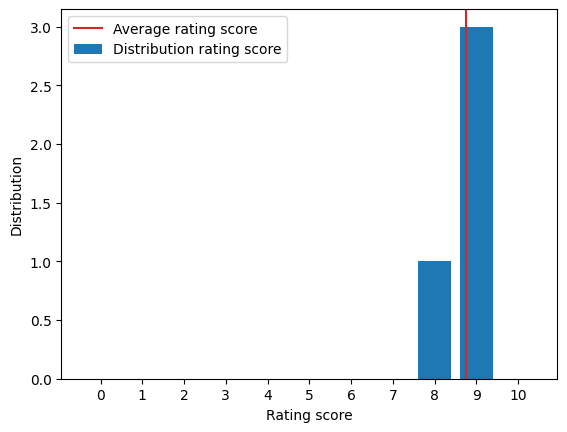

In [24]:
# Diplay rating scores in bar chart
import matplotlib.pyplot as plt
from operator import countOf

rating_scores = []
for question in questions:
    if 'rating_score' in question: 
        rating_scores.append(question['rating_score'])

bar_labels = []
rating_scores_count = []

for x in range(11):
    bar_labels.append(str(x))
    rating_scores_count.append(countOf(rating_scores,str(x)))

fig, ax = plt.subplots()
ax.bar(bar_labels, rating_scores_count)
ax.set_ylabel('Distribution')
ax.set_xlabel('Rating score')
plt.axvline(x=average_rating, color='tab:red')
plt.legend(['Average rating score','Distribution rating score'])
plt.show()


##### Generate explanation for average rating score

To explain the average rating score, each rating explanation can be used to create a summary and identiy areas for improvements to further optimize the application.

In [25]:
# Define prompt to summarize all ratings to explain the given average rating
summary_prompt_template = """HUMAN:
<role>Please act as an impartial summarizer and summarize the following explanations from a LLM as a judge to one single statement</role>
<task>Explain the main areas for improvement. Also, write a concise summary of the following explantions from a LLM as a judge to explain the average rating given which the LLM as judge gave. </task>

<average_rating>{average_rating}</average_rating>
<explanations>{explanations}</explanations>
ANSWER:"""
summary_prompt = PromptTemplate.from_template(summary_prompt_template)

In [26]:
explanation_avg_rating = eval_llm.invoke(summary_prompt.format(average_rating=average_rating, explanations=explanation_rating)).content

In [27]:
print(explanation_avg_rating)

**Summary:** The LLM exhibits significant improvement in generating coherent and creative responses, incorporating literary allusions, vivid imagery, and relevant cultural references. The average rating given by the judge is **8.75** based on the following strengths: accuracy, depth, creativity, and attention to detail. Areas for improvement include incorporating more examples and addressing non-verbal communication.
